# Text Classification Tutorial    
### by Daphné Le Cornec

This project focuses on text classification, one of the main tasks of Natural Language Processing. Here, the task consists of classifying names by origin.  
The data has been parsed from *https://adoption.com/baby-names/*.  

For more information on the framework, please refer to the related paper provided with this notebook.

In [1]:
!git clone https://github.com/DaphLC/name-classification.git

Cloning into 'name-classification'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [4]:
%cd name-classification/

/content/name-classification


In [6]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from collections import Counter

from models import LSTMWithAttn, SelfAttention
from data import Dataset, Vocab, collate_fn
from trainer import Trainer
from evaluation import (Plotter, prediction, custom_accuracy, evaluate,
                        unique_target)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import requests
import gensim
import random
import torch
import copy
import json
import time
import bs4

In [ ]:
# setting all random seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Load dataset

First, we load the dataset which has been parsed from *https://adoption.com/baby-names/* and cleaned.


In [7]:
with open('cleaned_names.jsonl', mode='r', encoding='utf8') as f:
    names_dataset = [json.loads(line) for line in f]

The dataset contains 90 618 rows. Below, an example of a name and its attribute in the dataset.

In [ ]:
print(len(names_dataset))
print(names_dataset[9])

90618
{'Name': 'Aaban', 'Meaning': 'Name of the Angels', 'Gender': 'Male', 'Origin': 'Arabic'}


## Data exploration

We create a dictionary by origin: it gives all the names in the dataset associated with the origin.

In [ ]:
by_origin = dict()
for name in names_dataset:
    if name['Origin'] not in by_origin:
        by_origin[name['Origin']] = list()
    by_origin[name['Origin']].append(name['Name'])

We shuffle the order of the names in the dictionary by origin so that when we create the train and test datasets, we have a shuffled list of names, not names ordered alphabetically.

In [ ]:
# shuffle list of names so that they are not ordered alphabetically
for origin, names in by_origin.items():
    random.shuffle(names)

For example, the French names in the dataset are:

In [ ]:
by_origin['French'][:10]

['Olivier',
 'Henry',
 'Matty',
 'Eveline',
 'Bellamy',
 'Dariel',
 'Ruff',
 'Raydon',
 'Joyelle',
 'Sebastien']

Then, we create a dictionary by name: it gives all the origins associated with a name.

In [ ]:
by_name = dict()
for name in names_dataset:
    if name['Name'] not in by_name:
        by_name[name['Name']] = list()
    by_name[name['Name']].append(name['Origin'])

For example, the name 'Alice' is associated to 7 different origins.

In [ ]:
by_name['Alice']

['French', 'English', 'German', 'Indian', 'Old-German', 'Greek', 'Celtic']

Now, we count how many name are associated to multiple origins, as it could be a problem when evaluating our models.

In [ ]:
# count how many names are associated with more than 1 origin
multiple_origins = {
    'one_origin': 0,
    'multiple_origins': 0
}
for name in by_name:
    if len(by_name[name]) == 1:
        multiple_origins['one_origin'] += 1
    else:
        multiple_origins['multiple_origins'] += 1       

We can see that 17 480 (28%) of the names in the dataset have multiple origins. The fact that a name can be associated with multiple origins will be taken into account during the evaluation phase of our models by considering that any prediction is correct if the origin is in the list of admissible origins associated with the input name.

In [ ]:
multiple_origins

{'one_origin': 44703, 'multiple_origins': 17480}

## Data selection

In our experiments, we decide to select 4 different origins, with relatively different names. We will semect only 2000 names by origin. To select origins with at least 2000 names  associated, we compute the number of names by origin.

In [ ]:
by_origin_len = {
    key: len(value)
    for key, value in by_origin.items()
}
by_origin_len = sorted(by_origin_len.items(), key=lambda item: item[1], reverse=True)

In [ ]:
by_origin_len[:12]

[('Indian', 35090),
 ('English', 6773),
 ('Arabic', 4827),
 ('Muslim', 3994),
 ('Bengali', 3195),
 ('Greek', 2753),
 ('Hebrew', 2486),
 ('Latin', 2279),
 ('Assemese', 2169),
 ('French', 2070),
 ('Biblical', 1846),
 ('Filipino', 1738)]

From this, we can see that only 10 origins have at least 2000 names. For our experiments, we will use French, Arabic, English and Greek.

In [ ]:
origins_selection = ['French', 'English', 'Greek', 'Arabic']
number_selection = 2000

We filter the original dataset based on our origins selection. We only keep the name and its origin as it is the only information needed to perform the classification task.

In [ ]:
filtered_names = [
    {'Name': names, 'Origin': origin}
    for origin in origins_selection
    for names in by_origin[origin][:number_selection]
]

In [ ]:
filtered_names[:10]

[{'Name': 'Olivier', 'Origin': 'French'},
 {'Name': 'Henry', 'Origin': 'French'},
 {'Name': 'Matty', 'Origin': 'French'},
 {'Name': 'Eveline', 'Origin': 'French'},
 {'Name': 'Bellamy', 'Origin': 'French'},
 {'Name': 'Dariel', 'Origin': 'French'},
 {'Name': 'Ruff', 'Origin': 'French'},
 {'Name': 'Raydon', 'Origin': 'French'},
 {'Name': 'Joyelle', 'Origin': 'French'},
 {'Name': 'Sebastien', 'Origin': 'French'}]

This filtered dataset will then be split between train and test dataset.

## Train - test split

Here, we use the classic sklearn split function to define train and test sets. We keep 30% of the data for the test set.

In [ ]:
names_list = [name['Name'] for name in filtered_names]
tgt_list = [name['Origin'] for name in filtered_names]

In [ ]:
train_names, test_names, train_tgt, test_tgt = train_test_split(
    names_list, tgt_list, test_size=0.3, stratify=tgt_list)

We then reconstruct the datasets with the name associated to its origin.

In [ ]:
train_set = [
    {'Name': name, 'Origin': origin}
    for name, origin in zip(train_names, train_tgt)
]
test_set = [
    {'Name': name, 'Origin': origin}
    for name, origin in zip(test_names, test_tgt)
]

In [ ]:
#sanity check
print(f'{len(train_set)=}')
print(f'{len(test_set)=}')

len(train_set)=5600
len(test_set)=2400


## Datasets creation

The train and test set are then passed through the Dataset class which constructs a dataset from a dictionary of names associated with origins (the train and test sets), a dictionary of admissible origins by name (by_name) and optional vocabularies (names and origins). In the train set, the names and origin vocabularies will be constructed at the character level according to the train_set. In the test set, we reuse the vocabularies constructed with the train set as this vocabulary will be used for the numericalization of the inputs and for the embedding models.  
The dataset numericalizes the inputs with respect to the names vocabulary. 

In [ ]:
train_dataset = Dataset(train_set, by_name)
test_dataset = Dataset(test_set, by_name, 
                   train_dataset.names_vocab, train_dataset.origin_vocab)

An example of the numericalized output is:

In [ ]:
print(train_set[10])
print(train_dataset[10])

{'Name': 'Euryalus', 'Origin': 'Greek'}
(tensor([22, 23, 19, 12,  8,  7, 23, 28]), tensor([6]), tensor([6]))


## Dataloader

The train and test datasets are then used for the Dataloader. As a reminder, the Dataloader create batchs from the datasets on which the models will be trained and evaluated. In our experiments, we use a bacth size of 4 and a custom collate function allowing to add padding to the inputs and keep in memory the inputs initial lengths, the target and the admissible targets.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=4, 
                                           shuffle=True, 
                                           collate_fn=collate_fn)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=4, 
                                          shuffle=False, 
                                          collate_fn=collate_fn)

## Char2Vec

Now, we will train a Char2Vec method (based on the Word2Vec method) on the data to retrieve embeddings at the character level specific to our task.  
In order to do so, we use the gensim library. The Char2Vec is established using the filtered names.

First, we retrieve the lists of names and origins.

In [ ]:
names_list = [name['Name'] for name in filtered_names]
tgt_list = [name['Origin'] for name in filtered_names]

We perform a sanity check by printing the lenght of the names and target lists which should be equal to the number of names selected times the number of origins selected (2000 * 4 in our case).

In [ ]:
print(f'{len(names_list)=}')
print(f'{len(tgt_list)=}')

len(names_list)=8000
len(tgt_list)=8000


Then, the gensim library requires to construct a Corpus yielding one input after another (here an input is a name).

In [ ]:
class MyCorpus():
    def __init__(self, names):
        self.names = names
        
    def __iter__(self):
        for name in self.names:
            yield list(name)

In [ ]:
characters = MyCorpus(names_list)

The Char2Vec model is then trained on the inputs with a window size of 3 and an embedding size of 128.

In [ ]:
%%time
char2vec = gensim.models.Word2Vec(characters, min_count=1, window=3, size=128)

CPU times: user 150 ms, sys: 6.14 ms, total: 156 ms
Wall time: 118 ms


The vocabulary at character level can then be retrieved from the Char2Vec model.

In [ ]:
char2vec_vocab = char2vec.wv.vocab

For example, we can show the statistics of each character of the vocabulary (number of appearance in the inputs, index in vocabulary, ...).

In [ ]:
char2vec_vocab['D'].__dict__

{'count': 540, 'index': 20, 'sample_int': 1724512337}

We also perform a sanity check to verify the shape of the embedding. It should be (128, ).

In [ ]:
# sanity check
char2vec.wv['D'].shape

(128,)

## Models

As mentionned in the report, we will test 4 models in our experiments: an LSTM and a Self-Attention model with pretrained embeddings (resp. *lstm* and *attn*), and, an LSTM and a Self-Attention model with Char2Vec embeddings (resp. *lstm_char2vec* and *attn_char2vec*)

The LSTM have two layers and are bidirectional. Their hidden dimension is 128.

In [ ]:
lstm = LSTMWithAttn(vocab=train_dataset.names_vocab,
                    hidden_dim=128,
                    n_classes=len(train_dataset.origin_vocab),
                    n_layers=2,
                    bidirectional=True)


In [ ]:
lstm

LSTMWithAttn(
  (embedding): Embedding(61, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, bidirectional=True)
  (out): Linear(in_features=256, out_features=7, bias=True)
)

In [ ]:
lstm_char2vec = LSTMWithAttn(vocab=train_dataset.names_vocab,
                            hidden_dim=128,
                            n_classes=len(train_dataset.origin_vocab),
                            n_layers=2,
                            bidirectional=True, 
                            char2vec = char2vec)

# sanity check
for char in train_dataset.names_vocab.vocab[3:]:
    idx = train_dataset.names_vocab.stoi(char)
    a = lstm_char2vec.embedding(torch.LongTensor([idx])).detach().numpy()
    b = char2vec.wv[char]
    assert (a == b).all()

The following tokens don't have pre-trained vectors and are initialized randomly:  ['<pad>', '<cls>', '<unk>']


In [ ]:
lstm_char2vec

LSTMWithAttn(
  (embedding): Embedding(61, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, bidirectional=True)
  (out): Linear(in_features=256, out_features=7, bias=True)
)

The Self-Attention models have a hidden dimension of 128, 1 head and 1 layer. (Some tests have been made with more heads and layers, and results do not improve).

In [ ]:
attn = SelfAttention(vocab=train_dataset.names_vocab,
                    hidden_dim=128,
                    n_classes=len(train_dataset.origin_vocab),
                    num_heads=1,
                    n_layers=1)

In [ ]:
attn

SelfAttention(
  (embedding): Embedding(61, 128, padding_idx=0)
  (positional_embedding): Embedding(50, 10)
  (attentions): ModuleList(
    (0): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=138, out_features=138, bias=True)
    )
  )
  (out): Linear(in_features=138, out_features=7, bias=True)
)

In [ ]:
attn_char2vec = SelfAttention(vocab=train_dataset.names_vocab,
                              hidden_dim=128,
                              n_classes=len(train_dataset.origin_vocab),
                              num_heads=1,
                              n_layers=1,
                              char2vec=char2vec)
# sanity check
for char in train_dataset.names_vocab.vocab[3:]:
    idx = train_dataset.names_vocab.stoi(char)
    a = attn_char2vec.embedding(torch.LongTensor([idx])).detach().numpy()
    b = char2vec.wv[char]
    assert (a == b).all()

The following tokens don't have pre-trained vectors and are initialized randomly:  ['<pad>', '<cls>', '<unk>']


## Train the model

We train the models with a learning rate of $10^{-3}$, a patience of 10 and 50 epochs.

In [ ]:
lr = 1e-3
patience = 10
n_epochs = 30

In [ ]:
lstm_trainer = Trainer(model=lstm, lr=lr, patience=patience)

In [ ]:
%%time
losses = lstm_trainer.train(train_loader=train_loader, 
                            test_loader=test_loader, 
                            epochs=n_epochs)

Step:500 Loss:1.1213824234902858 Eval:0.625
best score so far !!
Step:1000 Loss:1.0362184695601464 Eval:0.645
best score so far !!
Step:1500 Loss:0.9931824218432108 Eval:0.71125
best score so far !!
Step:2000 Loss:0.9528274572342634 Eval:0.7095833333333333
Step:2500 Loss:0.9217933468282222 Eval:0.71625
best score so far !!
Step:3000 Loss:0.8923632325902581 Eval:0.72625
best score so far !!
Step:3500 Loss:0.8665237633402326 Eval:0.75375
best score so far !!
Step:4000 Loss:0.8463138799511362 Eval:0.7345833333333334
Step:4500 Loss:0.8289394731834117 Eval:0.7516666666666667
Step:5000 Loss:0.8056690293153748 Eval:0.7520833333333333
Step:5500 Loss:0.7904573676689444 Eval:0.7675
best score so far !!
Step:6000 Loss:0.768921016733395 Eval:0.7804166666666666
best score so far !!
Step:6500 Loss:0.7504989585502413 Eval:0.7720833333333333
Step:7000 Loss:0.7346787038936995 Eval:0.7691666666666667
Step:7500 Loss:0.7137739337668366 Eval:0.7795833333333333
Step:8000 Loss:0.6970901292606068 Eval:0.77375

In [ ]:
lstm_c2v_trainer = Trainer(model=lstm_char2vec, lr=lr, patience=patience)

In [ ]:
%%time
losses = lstm_c2v_trainer.train(train_loader=train_loader, 
                               test_loader=test_loader, 
                               epochs=50)

Step:500 Loss:1.3217241733074188 Eval:0.4870833333333333
best score so far !!
Step:1000 Loss:1.200481954574585 Eval:0.54
best score so far !!
Step:1500 Loss:1.1608058240016301 Eval:0.5370833333333334
Step:2000 Loss:1.1319662450924515 Eval:0.5579166666666666
best score so far !!
Step:2500 Loss:1.1123207839131355 Eval:0.6195833333333334
best score so far !!
Step:3000 Loss:1.0917799574534097 Eval:0.6066666666666667
Step:3500 Loss:1.0701944253104074 Eval:0.615
Step:4000 Loss:1.055067142650485 Eval:0.6404166666666666
best score so far !!
Step:4500 Loss:1.0379136925935746 Eval:0.6733333333333333
best score so far !!
Step:5000 Loss:1.0225826453745366 Eval:0.6633333333333333
Step:5500 Loss:1.0090970711938358 Eval:0.6791666666666667
best score so far !!
Step:6000 Loss:0.99289642361179 Eval:0.6954166666666667
best score so far !!
Step:6500 Loss:0.97979963762657 Eval:0.6725
Step:7000 Loss:0.9675585450617863 Eval:0.70125
best score so far !!
Step:7500 Loss:0.9535642254394789 Eval:0.715
best score 

In [ ]:
attn_trainer = Trainer(model=attn, lr=lr, patience=patience)

In [ ]:
%%time
losses = attn_trainer.train(train_loader=train_loader, 
                            test_loader=test_loader, 
                            epochs=50)

Step:500 Loss:1.3052972197532653 Eval:0.47041666666666665
best score so far !!
Step:1000 Loss:1.273332990527153 Eval:0.47208333333333335
best score so far !!
Step:1500 Loss:1.251480328877767 Eval:0.4995833333333333
best score so far !!
Step:2000 Loss:1.2299215060323476 Eval:0.4995833333333333
Step:2500 Loss:1.2124556968688964 Eval:0.5325
best score so far !!
Step:3000 Loss:1.1980312816922862 Eval:0.5666666666666667
best score so far !!
Step:3500 Loss:1.1809264698901347 Eval:0.5604166666666667
Step:4000 Loss:1.1642175032068045 Eval:0.61625
best score so far !!
Step:4500 Loss:1.1489848571270704 Eval:0.61375
Step:5000 Loss:1.136407520286739 Eval:0.5879166666666666
Step:5500 Loss:1.1261088438697837 Eval:0.6108333333333333
Step:6000 Loss:1.1152944537736476 Eval:0.635
best score so far !!
Step:6500 Loss:1.1062735906369412 Eval:0.6279166666666667
Step:7000 Loss:1.0971327073456985 Eval:0.6358333333333334
best score so far !!
Step:7500 Loss:1.0903182856728633 Eval:0.63625
best score so far !!
S

In [ ]:
attn_c2v_trainer = Trainer(model=attn_char2vec, lr=lr, patience=patience)

In [ ]:
%%time
losses = attn_c2v_trainer.train(train_loader=train_loader, 
                            test_loader=test_loader, 
                            epochs=n_epochs)

Step:500 Loss:1.2946779745817185 Eval:0.5129166666666667
best score so far !!
Step:1000 Loss:1.1899928192794322 Eval:0.5975
best score so far !!
Step:1500 Loss:1.1423072173347075 Eval:0.5904166666666667
Step:2000 Loss:1.1133825916610658 Eval:0.59375
Step:2500 Loss:1.0950530863970518 Eval:0.5945833333333334
Step:3000 Loss:1.0776499574507277 Eval:0.6433333333333333
best score so far !!
Step:3500 Loss:1.065104850694537 Eval:0.6216666666666667
Step:4000 Loss:1.0531502963202075 Eval:0.6166666666666667
Step:4500 Loss:1.04263129228933 Eval:0.6275
Step:5000 Loss:1.0360822637431324 Eval:0.6458333333333334
best score so far !!
Step:5500 Loss:1.0297629484717141 Eval:0.6445833333333333
Step:6000 Loss:1.0225555858444422 Eval:0.6379166666666667
Step:6500 Loss:1.020079219440428 Eval:0.6629166666666667
best score so far !!
Step:7000 Loss:1.015830276108746 Eval:0.6479166666666667
Step:7500 Loss:1.0117966048444311 Eval:0.65
Step:8000 Loss:1.0078570534558966 Eval:0.62
Step:8500 Loss:1.0044795274147216 Ev

## Evaluation

The models are then evaluated using the weights associated with the best score from the training phase.

The weights are loaded:

In [ ]:
lstm.load_state_dict(lstm_trainer.best_weights)
lstm_char2vec.load_state_dict(lstm_c2v_trainer.best_weights)
attn.load_state_dict(attn_trainer.best_weights)
attn_char2vec.load_state_dict(attn_c2v_trainer.best_weights)

<All keys matched successfully>

We produce prediction for each model using the 'prediction' function defined in the validation pipeline. It predicts the output of an input with respect to a specified model. The function returns the list of admissible target (which are the true targets) and the predicted output.

In [ ]:
true_lstm, pred_lstm = prediction(lstm, test_loader)
true_lstm_c2v, pred_lstm_c2v = prediction(lstm_char2vec, test_loader)
true_attn, pred_attn = prediction(attn, test_loader)
true_attn_c2v, pred_attn_c2v = prediction(attn_char2vec, test_loader)

## Quantitative analysis

The models are then evaluated with respect to a custom accuracy score allowing multiple possible outputs. The results zre given below for each model.

In [ ]:
print(f'LSTM: {evaluate(true_lstm, pred_lstm)}')
print(f'LSTM with Char2Vec: {evaluate(true_lstm_c2v, pred_lstm_c2v)}')
print(f'Self-Attention: {evaluate(true_attn, pred_attn)}')
print(f'Self-Attention with Char2Vec: {evaluate(true_attn_c2v, pred_attn_c2v)}')

LSTM: 0.78917
LSTM with Char2Vec: 0.765
Self-Attention: 0.65792
Self-Attention with Char2Vec: 0.67958


The best performing model is the bidirectional LSTM with pretrained embeddings (no Char2Vec). Its accuracy score is 78.92%, whereas with Char2Vec embeddings, the score decrease to 76.50%. The Self-Attention model does not reach 70% of accuracy. The Self-Attention scores are higher with Char2Vec than without (resp. 67.96% and 65.79%). 

Then, we can show the confusion matrix to have a better view on which classes the models performs the best, and on which ones they make frequent mistakes. For the confusion matrix, we make a simple retreatment on data to have only one target by input, instead of the list of admissible targets as given by the prediction function.

In [ ]:
tgt_lstm = unique_target(true_lstm, pred_lstm)
tgt_lstm_c2v = unique_target(true_lstm_c2v, pred_lstm_c2v)
tgt_attn = unique_target(true_attn, pred_attn)
tgt_attn_c2v = unique_target(true_attn_c2v, pred_attn_c2v)

In [ ]:
def plot_conf_matrix(y_true, y_pred):
    '''
    Plot confusion matrix
    '''
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cf_matrix, annot=True, 
                xticklabels=train_dataset.origin_vocab[3:], 
                yticklabels=train_dataset.origin_vocab[3:])

The LSTM with pretrained embeddings reaches a performance of 92% of accuracy on the Arabic names, whereas the English class is only predicted right 68% of the time. Its most frequent mistake is to predict French when the true origin was English, which seems coherent since French and English names can be similar.

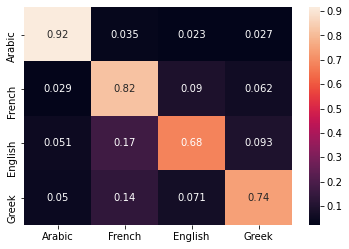

In [ ]:
plot_conf_matrix(tgt_lstm, pred_lstm)

The LSTM with Char2Vec embedding has a similar behaviour: its best performance is on the Arabic class, and its worst in the English class. This behaviour can be explained by the fact that Arabic names have a representation far from other classes.

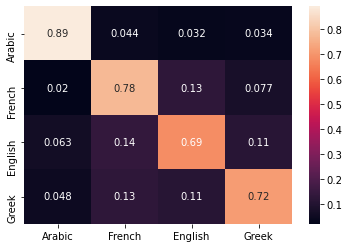

In [ ]:
plot_conf_matrix(tgt_lstm_c2v, pred_lstm_c2v)

The Self-Attention model with pretrained embeddings is performing poorly than the LSTM. Especially on the Greek class where only 51% of the Greek names are well classified. The Arabic class is still the one with the highest performance. The model seems to mix the other three classes as it makes frequent mistakes on these.

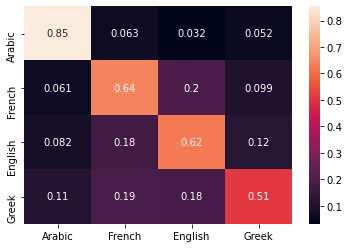

In [ ]:
plot_conf_matrix(tgt_attn, pred_attn)

When the Self-Attention model is trained based on Char2Vec embeddings, it seems to be performing slightly better on English and Greek classes but its performance on Arabic and French classes decrease by 5pts. Once again, the Arabic class is the one with the best performance.

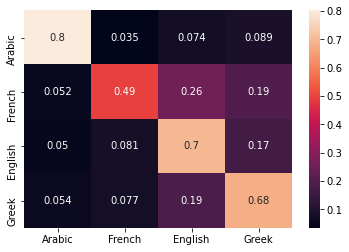

In [ ]:
plot_conf_matrix(tgt_attn_c2v, pred_attn_c2v)

## Qualitative analysis

In the last part of this project, we focuse on the qualitative results of the models. We do so by visualizing the attention weights of each model for a random input. The plot gives us the final attention weights of the model at the character level, and the probabilities of prediction for each classe.

In [ ]:
plt_lstm = Plotter(train_dataset.names_vocab, 
                   train_dataset.origin_vocab, lstm)
plt_lstm_c2v = Plotter(train_dataset.names_vocab, 
                       train_dataset.origin_vocab, lstm_char2vec)
plt_attn = Plotter(train_dataset.names_vocab, 
                   train_dataset.origin_vocab, attn)
plt_attn_c2v = Plotter(train_dataset.names_vocab, 
                       train_dataset.origin_vocab, attn_char2vec)

We choose to show that qualitative analysis on the name 'Daphné', but feel free to test any other name !

What can be seen from the following graphs is:  
- The LSTM models with and without Char2Vec embeddings seem to focus on only one character of the name to make predictions, especially with short names. Again, with the names that have been tested, it seems that the models are quite 'sure' about their predictions as a class is always predominant from the others. It may be the fact that it learned better representations of each class than the Self-Attention models.
- The Self-Attention models with and without Char2Vec seem to use more characters than the LSTM to make their predictions. Moreover, the probabilities of prediction are closer by class than with the LSTM. This may be the reason why these models perform poorer than the LSTM. It may be due to closer representation of each class, therefore hesitating between classes.

Note that it is possible that any example that has not been tested changes this conclusion.

In [ ]:
name_test = 'Daphné'

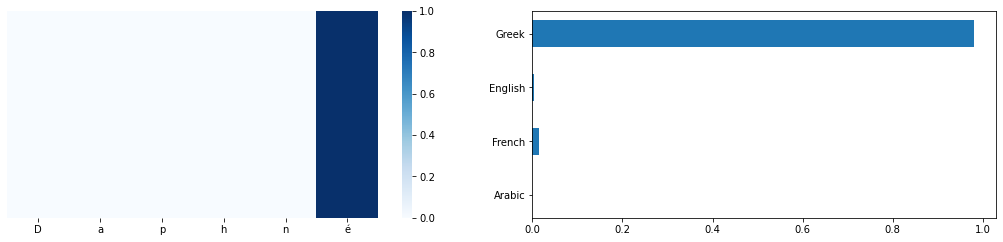

In [ ]:
plt_lstm.plot_attn_probas(name_test)

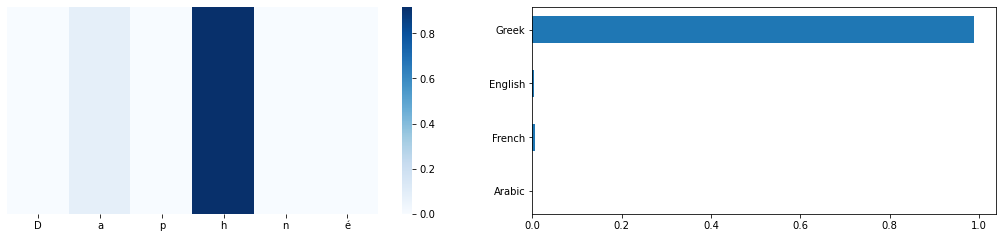

In [ ]:
plt_lstm_c2v.plot_attn_probas(name_test)

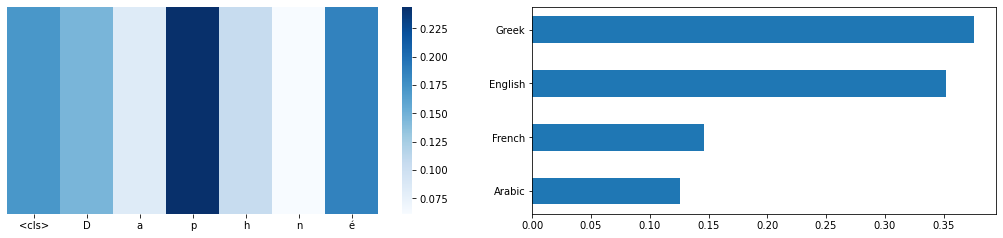

In [ ]:
plt_attn.plot_attn_probas(name_test)

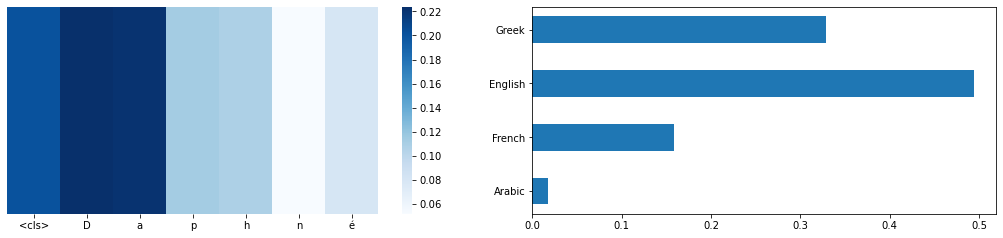

In [ ]:
plt_attn_c2v.plot_attn_probas(name_test)